# Ribonanza - Attempt 3

A second approach to the [Stanford Ribonanza problem](https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/) that builds off the first approach.

Major differences:
- use of attention model architecture
- use of only filtered data (data in which SN_filter == 1)

Currently, the attention architecture scores 0.20859

## Todo

- improve model 

## Setup

### Filesystem Setup

Your project directory should look like this:

- `(project directory)`
    - `ribonanza2.ipynb`
    - `train_data.csv`
    - `test_data.csv` (optional)

`train_data.csv` is the only file necessary for training, and it can be downloaded from the kaggle competition linked in the description.

`test_data.csv` is only necessary if you intend to make and submit predictions.

### Code Setup

In [1]:
# imports
import torch
import pandas
import numpy as np
from tqdm import tqdm
import seaborn
import os

In [2]:
# constants

# according to kaggle, this is the maximum # of reactivites to be used
NUM_REACTIVITIES = 457

# there are 4 different bases (AUCG)
NUM_BASES = 4

## Data Preprocessing

### Filter Data

In [3]:
def filter_data(out: str, key: str, value: str, file_name: str, force: bool):
    """
    Filters a file to only take datapoints
    whose values of `key` are `value`.

    Parameters:
        - out: str - the name of the file that will store the filtered datapoints
        - key: str - the name of the key to look at
        - value: str - the value that the key should have
        - file_name: str - the name of the file that contains all the datapoints.
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    if os.path.exists(out) and not force:
        print("File already exists, not doing any work")
        return

    count = 0

    # count how many lines we have in total
    with open(file_name) as file:
        line = file.readline()  # ignore the header
        line = (
            file.readline()
        )  # take the first line since we increment count in the loop
        while line != "":
            count += 1
            line = file.readline()

    # use that knowledge for a progress bar
    with open(file_name, "r") as file, open(out, "w") as outfile:
        # write the header
        header = file.readline()
        outfile.write(header)

        # get what index the SN_filter is
        SN_idx = header.split(",").index(key)

        # only take the approved filtered lines
        for _ in tqdm(range(count)):
            line = file.readline()
            temp = line.split(",")
            if temp[SN_idx] == value:
                outfile.write(line)


def filter_train_data(force: bool = False):
    """
    Filters the immense train_data.csv to only take datapoints
    whose SN_filter (Signal to Noise filter) is 1. In other words,
    we only take good reads. These filtered datapoints are then
    written to the file provided

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data("train_data_filtered.csv", "SN_filter", "1", "train_data.csv", force)


def filter_2A3(force: bool = False):
    """
    Only take the 2A3 points

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data(
        "train_data_2a3.csv",
        "experiment_type",
        "2A3_MaP",
        "train_data_filtered.csv",
        force,
    )


def filter_DMS(force: bool = False):
    """
    Only take the DMS points

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data(
        "train_data_dms.csv",
        "experiment_type",
        "DMS_MaP",
        "train_data_filtered.csv",
        force,
    )

In [4]:
# filter our data
filter_train_data()

File already exists, not doing any work


In [5]:
# take the 2a3 points
filter_2A3()

File already exists, not doing any work


In [6]:
# take the dms points
filter_DMS()

File already exists, not doing any work


### Convert Data to Inputs and Outputs

In [7]:
# encode inputs as
# A : 1
# U : 2
# C : 3
# G : 4
base_map = {
    "A": 1,
    "U": 2,
    "C": 3,
    "G": 4,
}

In [8]:
def preprocess_csv(out: str, file_name: str, force: bool = False):
    """
    Preprocess the csv and save the preprocessed data as a .npz file

    Parameters:
        - out: str - the name of the file to save the arrays to
        - file_name: str - the name of the input csv file
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done).
                Defaults to `False`
    """
    if os.path.exists(out) and not force:
        print("File already exists, not doing any work")
        return

    df = pandas.read_csv(file_name)

    inputs = np.zeros((len(df), NUM_REACTIVITIES))
    outputs = np.zeros((len(df), NUM_REACTIVITIES))
    output_masks = np.ones((len(df), NUM_REACTIVITIES), dtype=np.bool_)
    errors = np.zeros((len(df), NUM_REACTIVITIES))

    for index in tqdm(range(len(df))):
        row = df.iloc[index]

        # get the sequence
        seq_len = len(row["sequence"])

        # map the base to its one-hot encoding
        inputs[index, :seq_len] = np.array(
            list(map(lambda letter: base_map[letter], row["sequence"]))
        )

        # get all the reactivities and reactivity errors
        reactivities = np.array(
            list(
                map(
                    lambda seq_idx: row["reactivity_" + str(seq_idx + 1).rjust(4, "0")],
                    range(seq_len),
                )
            )
        )
        reactivity_errors = np.array(
            list(
                map(
                    lambda seq_idx: row[
                        "reactivity_error_" + str(seq_idx + 1).rjust(4, "0")
                    ],
                    range(seq_len),
                )
            )
        )

        # replace reactivity error nans with 0s (assume no error)
        reactivity_errors = np.where(
            np.isnan(reactivity_errors), 0.0, reactivity_errors
        )

        # get where all the reactivities are nan
        nan_locats = np.isnan(reactivities)

        # where it is nan, store True, else false
        output_masks[index, :seq_len] = nan_locats

        # where it is not nan, store the reactivity and error, else 0
        outputs[index, :seq_len] = np.where(nan_locats == False, reactivities, 0.0)
        errors[index, :seq_len] = np.where(nan_locats == False, reactivity_errors, 0.0)

    # save the outputs
    np.savez_compressed(
        out, inputs=inputs, outputs=outputs, output_masks=output_masks, errors=errors
    )

In [9]:
preprocess_csv("train_data_2a3_preprocessed.npz", "train_data_2a3.csv")

File already exists, not doing any work


In [10]:
preprocess_csv("train_data_dms_preprocessed.npz", "train_data_dms.csv")

File already exists, not doing any work


### Load the desired dataset

In [11]:
desired_dataset = "2a3"  # either "2a3" or "dms"

In [12]:
import torch.utils.data as data

# load the npz file
npz_file = np.load(f"train_data_{desired_dataset}_preprocessed.npz")

# stored inputs, outputs, and output_masks
full_dataset = data.TensorDataset(
    torch.tensor(npz_file["inputs"], dtype=torch.float32),
    torch.tensor(np.clip(npz_file["outputs"], 0, 1), dtype=torch.float32),
    torch.tensor(
        np.clip(
            np.where(npz_file["output_masks"], 0.0, 1.0) - np.abs(npz_file["errors"]),
            0,
            1,
        ),
        dtype=torch.float32,
    ),
)

# split into train, val
train_dataset, val_dataset = data.random_split(full_dataset, lengths=[0.9, 0.1])

# close the npz file
npz_file.close()

In [13]:
print(
    "train set is len", len(train_dataset), "and val dataset is len", len(val_dataset)
)

train set is len 189893 and val dataset is len 21099


### Visualize

This section of the notebook allows for visualizing the reactivities of the
current dataset.

In [14]:
visualize = False

In [15]:
if visualize:
    npz_file = np.load(f"train_data_{desired_dataset}_preprocessed.npz")
    outputs, bool_output_masks = npz_file["outputs"], npz_file["output_masks"]
    npz_file.close()
    visualized_items = []
    for i in tqdm(range(len(outputs))):
        for x in range(NUM_REACTIVITIES):
            if not bool_output_masks[i, x]:
                visualized_items.append(outputs[i, x])
    visualized_items = np.array(visualized_items)
    print(f"took {len(visualized_items)}/{len(outputs)*NUM_REACTIVITIES} reactivities")
else:
    print("Not visualizing. Set `visualize` to `True` to visualize data")

Not visualizing. Set `visualize` to `True` to visualize data


In [16]:
if visualize:
    seaborn.histplot(visualized_items, binwidth=0.1)
else:
    print("Not visualizing. Set `visualize` to `True` to visualize data")

Not visualizing. Set `visualize` to `True` to visualize data


## Model

In [17]:
import xformers.components.positional_embedding as embeddings
import xformers.ops as xops
import xformers.components.attention as attentions
import xformers.components.attention.utils as att_utils
import xformers.components as components

In [18]:
class MemoryEfficientSelfAttention(torch.nn.Module):
    def __init__(
        self, latent_dim: int, n_heads: int, dropout: float, *args, **kwargs
    ) -> None:
        super(MemoryEfficientSelfAttention, self).__init__()
        self.n_heads = n_heads
        self.latent_dim = latent_dim
        self.dropout = dropout

        assert latent_dim % n_heads == 0

    def forward(self, x: torch.Tensor, **kwargs):
        # B, Seq Len, embedding -> B, Seq Len, Heads, Embedding per head
        x = x.reshape(x.shape[0], x.shape[1], self.n_heads, x.shape[2] // self.n_heads)
        x = xops.memory_efficient_attention(x, x, x, p=self.dropout)
        x = x.reshape(x.shape[0], x.shape[1], -1)

        return x


class SDPAttention(torch.nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        dropout: float,
        device: str,
        *args,
        **kwargs
    ) -> None:
        super(SDPAttention, self).__init__()
        self.mha = components.MultiHeadDispatch(
            latent_dim,
            num_heads=n_heads,
            attention=attentions.ScaledDotProduct(dropout=dropout),
        ).to(device)

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor):
        return self.mha(x, att_mask=attention_mask)


class SlidingWindowAttention(torch.nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        dropout: float,
        device: str,
        *args,
        **kwargs
    ) -> None:
        super(SlidingWindowAttention, self).__init__()
        self.mha = components.MultiHeadDispatch(
            latent_dim,
            n_heads,
            attentions.LocalAttention(
                dropout=dropout, window_size=kwargs["context_window"]
            ),
        ).to(device)

    def forward(self, x: torch.Tensor, **kwargs):
        return self.mha(x)

In [19]:
class CustomTransformerEncoderLayer(torch.nn.Module):
    def __init__(
        self,
        attention_type: torch.nn.Module,
        latent_dim: int,
        ff_dim: int,
        n_heads: int,
        dropout: float = 0.1,
        device: str = "cuda",
        *args,
        **kwargs
    ) -> None:
        super(CustomTransformerEncoderLayer, self).__init__()
        self.attention = attention_type(
            latent_dim=latent_dim,
            n_heads=n_heads,
            dropout=dropout,
            device=device,
            **kwargs
        )
        self.layer_norm = torch.nn.LayerNorm(latent_dim).to(device)

        self.ff1 = torch.nn.Linear(latent_dim, ff_dim).to(device)
        self.ff2 = torch.nn.Linear(ff_dim, latent_dim).to(device)
        self.gelu = torch.nn.GELU()

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor):
        # MHA, add, norm
        x = self.layer_norm(self.attention(x, attention_mask=attention_mask) + x)

        # ff, add, norm
        x = self.layer_norm(self.gelu(self.ff2(self.gelu(self.ff1(x)))) + x)

        return x


class CustomTransformerEncoder(torch.nn.Module):
    def __init__(
        self,
        attention_type: torch.nn.Module,
        n_layers: int,
        latent_dim: int,
        ff_dim: int,
        n_heads: int,
        dropout: float = 0.1,
        device: str = "cuda",
        **kwargs
    ) -> None:
        super(CustomTransformerEncoder, self).__init__()
        for i in range(n_layers):
            self.add_module(
                str(i),
                CustomTransformerEncoderLayer(
                    attention_type=attention_type,
                    latent_dim=latent_dim,
                    ff_dim=ff_dim,
                    n_heads=n_heads,
                    dropout=dropout,
                    device=device,
                    **kwargs
                ),
            )

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor):
        for module in self._modules.values():
            x = module(x, attention_mask=attention_mask)
        return x


class AttentionModel(torch.nn.Module):
    def __init__(
        self,
        attention_type: torch.nn.Module,
        context_window: int = 31,
        latent_dim: int = 128,
        ff_dim: int = 1024,
        n_heads: int = 2,
        enc_layers: int = 1,
        device: str = "cuda",
    ) -> None:
        super(AttentionModel, self).__init__()

        # data
        self.n_heads = n_heads
        self.latent_dim = latent_dim

        # prepatory conv layers
        self.conv_layer = torch.nn.Conv1d(
            1, out_channels=latent_dim, kernel_size=context_window, padding="same"
        ).to(device)
        self.conv_layer_b = torch.nn.Conv1d(
            1, out_channels=latent_dim, kernel_size=context_window, padding="same"
        ).to(device)

        # positional embedding and encoder layers
        self.pos_embedding = embeddings.SinePositionalEmbedding(latent_dim).to(device)
        self.encoder_layers = CustomTransformerEncoder(
            latent_dim=latent_dim,
            ff_dim=ff_dim,
            n_heads=n_heads,
            device=device,
            attention_type=attention_type,
            n_layers=enc_layers,
            context_window=context_window,
        )

        # output head
        self.head = torch.nn.Linear(latent_dim, 1).to(device)
        self.final_result = torch.nn.Linear(NUM_REACTIVITIES, NUM_REACTIVITIES).to(
            device
        )

        # activations
        self.relu = torch.nn.ReLU()
        self.gelu = torch.nn.GELU()

    def _forward(self, x: torch.Tensor):
        mask = att_utils.maybe_merge_masks(
            att_mask=None,
            key_padding_mask=x != 0,
            batch_size=x.shape[0],
            num_heads=self.n_heads,
            src_len=x.shape[1],
        )
        x = x.reshape(x.shape[0], 1, x.shape[1])
        # print(x.shape)

        x = self.gelu(
            self.conv_layer(x)
            + torch.flip(self.conv_layer_b(torch.flip(x, dims=[2])), dims=[2])
        )
        # print(x.shape)

        x = x.permute((0, 2, 1)).contiguous()

        x = self.pos_embedding(x)
        x = self.encoder_layers(x, attention_mask=mask)

        x = self.relu(self.final_result(self.gelu(self.head(x).flatten(start_dim=1))))
        # print(x.shape)
        return x

    # used for calculating lr to use
    def weightedForward(self, x: torch.Tensor, weights: torch.Tensor):
        self.weights = weights
        return self._forward(x)

    def weightedLoss(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        return (
            (torch.nn.L1Loss()(y_pred.cuda(), y_true.cuda()) * self.weights.cuda())
            .sum(dim=-1)
            .mean()
        )

    def configure_for_lr_testing(self):
        self.forward = self.weightedForward

    def configure_for_training(self):
        self.forward = self._forward

In [20]:
class BaselineModel(torch.nn.Module):
    def __init__(self, context_window: int = 31, device: str = "cuda"):
        super(BaselineModel, self).__init__()
        self.conv_layer = torch.nn.Conv1d(1, 1, context_window, padding="same").to(
            device
        )
        self.conv_layer_b = torch.nn.Conv1d(1, 1, context_window, padding="same").to(
            device
        )
        self.ff = torch.nn.Linear(NUM_REACTIVITIES, NUM_REACTIVITIES).to(device)
        self.gelu = torch.nn.GELU()
        self.relu = torch.nn.ReLU()

    def _forward(self, x: torch.Tensor):
        x = x.reshape(x.shape[0], 1, x.shape[1])

        x = self.gelu(
            self.conv_layer(x)
            + torch.flip(self.conv_layer_b(torch.flip(x, dims=[2])), dims=[2])
        )

        return self.relu(self.ff(x.flatten(start_dim=1)))

    def weightedForward(self, x: torch.Tensor, weights: torch.Tensor):
        self.weights = weights
        return self._forward(x)

    def weightedLoss(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        return (
            (torch.nn.L1Loss()(y_pred.cuda(), y_true.cuda()) * self.weights.cuda())
            .sum(dim=-1)
            .mean()
        )

    def configure_for_lr_testing(self):
        self.forward = self.weightedForward

    def configure_for_training(self):
        self.forward = self._forward

In [21]:
model_dms_kwargs = dict(
    latent_dim=32, n_heads=4, enc_layers=2, ff_dim=256, attention_type=SDPAttention
)
model_2a3_kwargs = dict(
    latent_dim=32, n_heads=4, enc_layers=2, ff_dim=256, attention_type=SDPAttention
)

In [22]:
if desired_dataset == "dms":
    model = AttentionModel(**model_dms_kwargs)
elif desired_dataset == "2a3":
    model = AttentionModel(**model_2a3_kwargs)
# model= BaselineModel()

In [23]:
inp = torch.zeros((2, NUM_REACTIVITIES))
inp[:, 0] = 1

In [24]:
model.configure_for_training()
model(inp.cuda()).cpu().detach()

tensor([[0.0000e+00, 5.3057e-02, 4.4558e-01, 6.5869e-03, 0.0000e+00, 1.1272e-01,
         2.6484e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1126e-02, 8.8696e-04, 1.7578e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.3540e-02, 7.5706e-03, 1.1682e-02, 3.5635e-01, 0.0000e+00,
         1.4374e-01, 5.5607e-01, 4.3531e-01, 0.0000e+00, 2.0895e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 3.3457e-01, 4.7717e-01, 0.0000e+00, 3.2619e-01,
         4.5629e-01, 0.0000e+00, 2.0239e-01, 3.1963e-01, 0.0000e+00, 1.5677e-01,
         7.6257e-02, 3.8343e-01, 2.6197e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.8042e-01, 0.0000e+00,
         2.4630e-01, 4.7028e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4386e-01,
         5.1121e-01, 1.7544e-01, 0.0000e+00, 3.0134e-01, 0.0000e+00, 0.0000e+00,
         1.3123e-01, 7.9583e-02, 1.3463e-01, 2.9989e-02, 4.7034e-01, 0.0000e+00,
         0.0000e+00, 0.0000e

In [25]:
print(model)

AttentionModel(
  (conv_layer): Conv1d(1, 32, kernel_size=(31,), stride=(1,), padding=same)
  (conv_layer_b): Conv1d(1, 32, kernel_size=(31,), stride=(1,), padding=same)
  (pos_embedding): SinePositionalEmbedding()
  (encoder_layers): CustomTransformerEncoder(
    (0): CustomTransformerEncoderLayer(
      (attention): SDPAttention(
        (mha): MultiHeadDispatch(
          (attention): ScaledDotProduct(
            (attn_drop): Dropout(p=0.1, inplace=False)
          )
          (in_proj_container): InputProjection(
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (resid_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=32, out_features=32, bias=True)
        )
      )
      (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ff1): Linear(in_features

In [26]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Total params:", params)

Total params: 253307


SuggestedLRs(valley=0.010964781977236271)

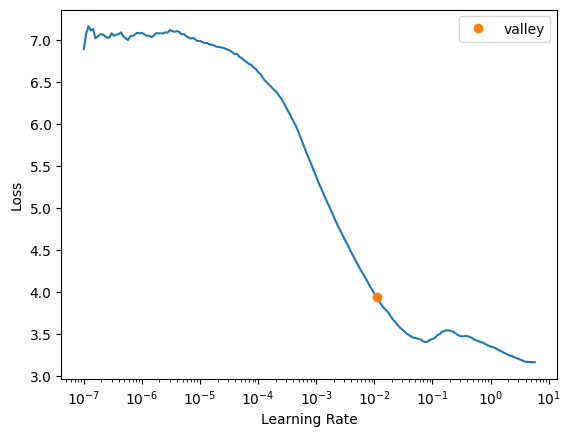

In [27]:
import fastai.learner as learner
import fastai.callback.schedule
import fastai.data.core as fdata

model.configure_for_lr_testing()
learner.Learner(
    fdata.DataLoaders(
        data.DataLoader(train_dataset, batch_size=32, shuffle=True),
        data.DataLoader(val_dataset, batch_size=32, shuffle=True),
    ),
    model,
    loss_func=model.weightedLoss,
).lr_find(stop_div=False, num_it=200)

In [28]:
model.configure_for_training()

In [29]:
optimizer = torch.optim.Adam(model.parameters(), 2e-3)

## Train

In [30]:
BATCH_SIZE = 128
SHUFFLE = True

train_dataloader = data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE
)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)  # no point in shuffling val

In [31]:
def weightedL1(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    weights: torch.Tensor,
    l1=torch.nn.L1Loss(),
):
    return (l1(y_pred, y_true) * weights).sum(dim=-1).mean()

In [32]:
def train_batch(
    m: torch.nn.Module, inps: torch.Tensor, outs: torch.Tensor, masks: torch.Tensor
):
    """
    Get the loss on a batch and perform the corresponding weight updates.
    Used for training purposes
    """
    optimizer.zero_grad()
    loss = weightedL1(m(inps), outs, masks)

    loss.backward()

    # calculate gradients
    optimizer.step()

    # return mae loss
    return loss


def noupdate_batch(
    m: torch.nn.Module, inps: torch.Tensor, outs: torch.Tensor, masks: torch.Tensor
):
    """
    Get the loss on a batch without performing any updates.
    Used for validation purposes
    """
    with torch.no_grad():
        loss = weightedL1(m(inps), outs, masks)

    # return mae loss
    return loss


def masked_train(
    m: torch.nn.Module,
    train_dataloader: data.DataLoader,
    val_dataloader: data.DataLoader,
    epochs: int = 1,
    device: str = "cuda",
):
    """
    Train the given model.

    Arguments:
        - m: keras.Model - the model to train.
        - x: np.ndarray - the numpy array of inputs.
        - y: np.ndarray - the numpy array of outputs.
        - masks: np.ndarray - the sample weights (1s and 0s).
        - batch_size: int - how large the batches should be. Defaults to `32`.
        - epochs: int - how many epochs to train for. Defaults to `1`.
        - validation_split: float - how large the validation subset should be, in the range (0, 1]. Defaults to `0.1`.

    Note - The choice of np.ndarray is purely arbitrary, and this function can be modified to use tf.Tensors

    Note - shuffle code is provided in numpy, but commented out because of memory limitations that less powerful computers
    may encounter.
    """
    # shuffle
    # shuffled_idxs = np.arange(x.shape[0])
    # np.random.shuffle(shuffled_idxs)
    # x = x[shuffled_idxs]
    # y = y[shuffled_idxs]
    # masks = masks[shuffled_idxs]
    m = m.to(device)

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}")
        epoch_mae = 0.0

        m = m.train()
        for batch, tdata in enumerate(train_dataloader):
            inps, outs, masks = tdata

            inps = inps.to(device)
            outs = outs.to(device)
            masks = masks.to(device)

            mae_loss = train_batch(m, inps, outs, masks).detach().cpu()

            epoch_mae += mae_loss

            # log
            print(
                f"Batch {batch+1}/{len(train_dataloader)}\t- mae loss: {mae_loss:.5f}",
                end="\r",
            )

            # break  # used for sanity check
        epoch_mae /= len(train_dataloader)

        # do validation
        val_mae = 0.0
        m = m.eval()
        for batch, vdata in enumerate(val_dataloader):
            inps, outs, masks = vdata
            inps = inps.to(device)
            outs = outs.to(device)
            masks = masks.to(device)
            mae_loss = noupdate_batch(m, inps, outs, masks)

            val_mae += mae_loss
        val_mae /= len(val_dataloader)

        # shuffle
        # shuffled_idxs = np.arange(x.shape[0])
        # np.random.shuffle(shuffled_idxs)
        # x = x[shuffled_idxs]
        # y = y[shuffled_idxs]
        # masks = masks[shuffled_idxs]

        print()
        print(f"Epoch MAE: {epoch_mae:.5f}\tVal MAE: {val_mae:.5f}")

In [33]:
# baseline gets ~ 3.64968 on dms w/ 10 epochs, ~ 4.64478 on 2a3 w/ 10 epochs
masked_train(
    model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, epochs=5
)

Epoch 1
Batch 1484/1484	- mae loss: 4.56457
Epoch MAE: 4.73672	Val MAE: 4.59158
Epoch 2
Batch 1484/1484	- mae loss: 4.22912
Epoch MAE: 4.47730	Val MAE: 4.35422
Epoch 3
Batch 1484/1484	- mae loss: 3.93581
Epoch MAE: 4.25839	Val MAE: 4.18861
Epoch 4
Batch 1484/1484	- mae loss: 3.91748
Epoch MAE: 4.12989	Val MAE: 4.08329
Epoch 5
Batch 1484/1484	- mae loss: 4.16344
Epoch MAE: 4.04672	Val MAE: 4.01285


## Save

This section saves the current model

In [34]:
torch.save(model.state_dict(), f"{desired_dataset}_model")

## Process Outputs

This section of the noteboook creates a zipped csv submission file that can
be submitted on Kaggle.

In [35]:
make_submissions = True

In [39]:
valid = False

if (
    os.path.exists("2a3_model")
    and os.path.exists("dms_model")
    and os.path.exists("test_sequences.csv")
    and make_submissions
):
    valid = True
    model_2a3 = AttentionModel(**model_2a3_kwargs)
    model_2a3.load_state_dict(torch.load("2a3_model"))
    model_dms = AttentionModel(**model_dms_kwargs)
    model_dms.load_state_dict(torch.load("dms_model"))

    model_2a3.eval().cuda().configure_for_training()
    model_dms.eval().cuda().configure_for_training()
else:
    print("Not going to create submissions.")

In [40]:
def pipeline(
    model_2a3: torch.nn.Module,
    model_dms: torch.nn.Module,
    input_csv: str,
    out: str,
    batch_size: int,
):
    """
    Process test data and write submissions to a csv file

    Arguments:
        - model_2a3: keras.Model - the model trained on the 2a3 distribution
        - model_dms: keras.Model - the model trained on the dms distribution
        - input_csv: str - the name of the file that contains the test data
        - out: str - the name of the file to write predictions to
        - batch_size: int - how many predictions to make at a time
    """
    count = 0

    # count how many lines we have in total
    with open(input_csv) as file:
        line = file.readline()  # ignore the header
        # take the first line since we increment count in the loop
        line = file.readline()
        while line != "":
            count += 1
            line = file.readline()

    # use that knowledge for a progress bar
    with open(input_csv, "r") as file, open(out, "w") as outfile:
        # write the header
        outfile.write("id,reactivity_DMS_MaP,reactivity_2A3_MaP\n")

        # get what index the things we need are
        header = file.readline()
        split_header = header.split(",")
        min_idx = split_header.index("id_min")
        max_idx = split_header.index("id_max")
        sequence_idx = split_header.index("sequence")

        # only take the approved filtered lines
        num_batches = count // batch_size
        if count % batch_size != 0:
            num_batches += 1
        for batch in tqdm(range(num_batches)):
            num_items = min(batch_size, count - batch * batch_size)

            # initialize variables
            inputs = np.zeros((num_items, NUM_REACTIVITIES))
            min_seq_idxs = []
            sequence_lengths = []

            # collect the inputs
            for i in range(num_items):
                line = file.readline()
                temp = line.split(",")
                sequence = temp[sequence_idx]
                max_seq_idx = int(temp[max_idx])
                min_seq_idx = int(temp[min_idx])

                # verify that everything is correct
                assert len(sequence) + min_seq_idx - 1 == max_seq_idx

                # store the data
                inputs[i, : len(sequence)] = np.array(
                    list(map(lambda letter: base_map[letter], sequence))
                )
                min_seq_idxs.append(min_seq_idx)
                sequence_lengths.append(len(sequence))

            # run inputs through the associated model
            inputs = torch.tensor(inputs, dtype=torch.float32).cuda()
            with torch.no_grad():
                probs_2a3, probs_dms = model_2a3(inputs), model_dms(inputs)
            probs_dms = probs_dms.cpu()
            probs_2a3 = probs_2a3.cpu()

            # write predictions
            for i in range(num_items):
                for seq_idx in range(
                    min_seq_idxs[i], min_seq_idxs[i] + sequence_lengths[i]
                ):
                    outfile.write(
                        f"{seq_idx},{probs_dms[i, seq_idx - min_seq_idxs[i]]:.3f},{probs_2a3[i, seq_idx - min_seq_idxs[i]]:.3f}\n"
                    )

In [42]:
if valid:
    pipeline(
        model_2a3, model_dms, "test_sequences.csv", "submission.csv", batch_size=256
    )
else:
    print("Not going to create submissions.")

100%|██████████| 5250/5250 [1:06:03<00:00,  1.32it/s]


In [43]:
if valid:
    # zip our submission into an easily-uploadable zip file
    print("zipping submissions. This may take a while...")
    os.system("zip submission.csv.zip submission.csv")
    print("Done zipping submissions!")
else:
    print("Not going to zip submissions.")

zipping submissions. This may take a while...
updating: submission.csv (deflated 81%)
Done zipping submissions!
